In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

### 1. EDA & Feature Engineering

##### Load the Titanic dataset.

In [50]:
df = pd.read_csv(r"D:\BlackBucks\Assignments\Assignment-3\titanic\train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


##### Handle missing values (Age, Embarked, etc.).

In [51]:
print(df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [52]:
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

##### Extract Title from the Name column.

In [53]:
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [54]:
rare_titles = df['Title'].value_counts()[df['Title'].value_counts() < 10].index
df['Title'] = df['Title'].replace(rare_titles, 'Rare')

In [55]:
# Drop unnecessary columns
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

##### Convert categorical columns (Sex, Embarked, Title) using Label Encoding.

In [56]:
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])
df['Embarked'] = le.fit_transform(df['Embarked'])
df['Title'] = le.fit_transform(df['Title'])

In [57]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,1,22.0,1,0,7.2500,2,2
1,1,1,0,38.0,1,0,71.2833,0,3
2,1,3,0,26.0,0,0,7.9250,2,1
3,1,1,0,35.0,1,0,53.1000,2,3
4,0,3,1,35.0,0,0,8.0500,2,2


In [58]:
X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2. Decision Tree Classifier

##### Train with criterion='gini' and 'entropy'.

In [59]:
# Gini
dt_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_split=5)
dt_gini.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_split=5)

In [60]:
# Entropy
dt_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=5)
dt_entropy.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=5)

##### Visualizing the tree using plot_tree.

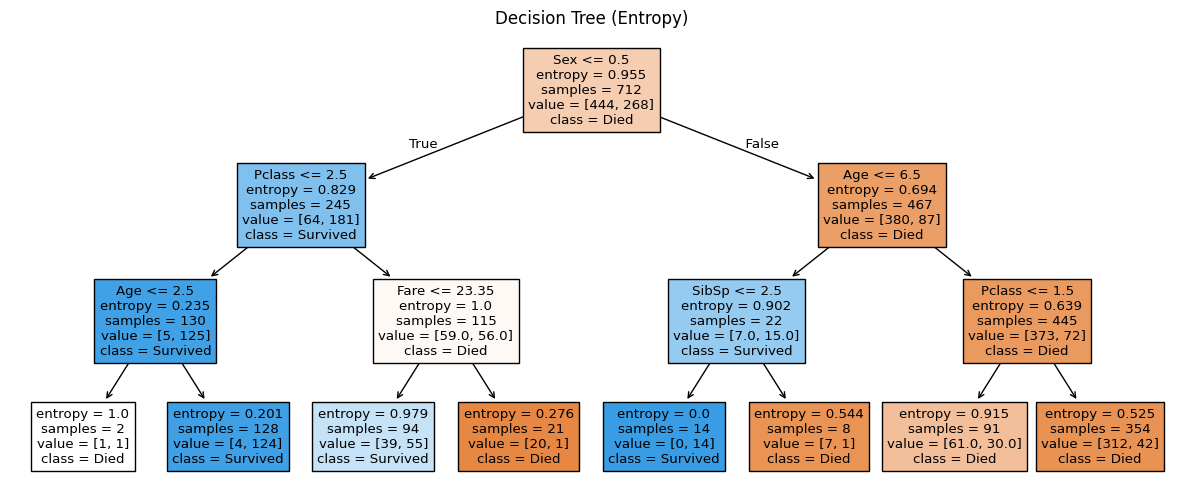

In [61]:
plt.figure(figsize=(15, 6))
plot_tree(dt_entropy, feature_names=X.columns, class_names=['Died', 'Survived'], filled=True)
plt.title("Decision Tree (Entropy)")
plt.show()

### 3. Cross Validation

In [62]:
scores = cross_val_score(dt_entropy, X, y, cv=5)
print("Cross-Validation Scores:", scores)
print("Average CV Score:", scores.mean())

Cross-Validation Scores: [0.82122905 0.80898876 0.82022472 0.79213483 0.85393258]
Average CV Score: 0.8193019898311469


### 4. Bagging Classifier

In [63]:
# Train a Single Decision Tree 
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)

print("Single Decision Tree Accuracy:", accuracy_score(y_test, dt_preds))

Single Decision Tree Accuracy: 0.776536312849162


In [64]:
# Updated syntax for newer versions of scikit-learn
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, bootstrap=True, random_state=42)
bagging.fit(X_train, y_train)
bag_preds = bagging.predict(X_test)

print("Bagging Accuracy:", accuracy_score(y_test, bag_preds))

Bagging Accuracy: 0.8156424581005587


### 5. Random Forest Classifier

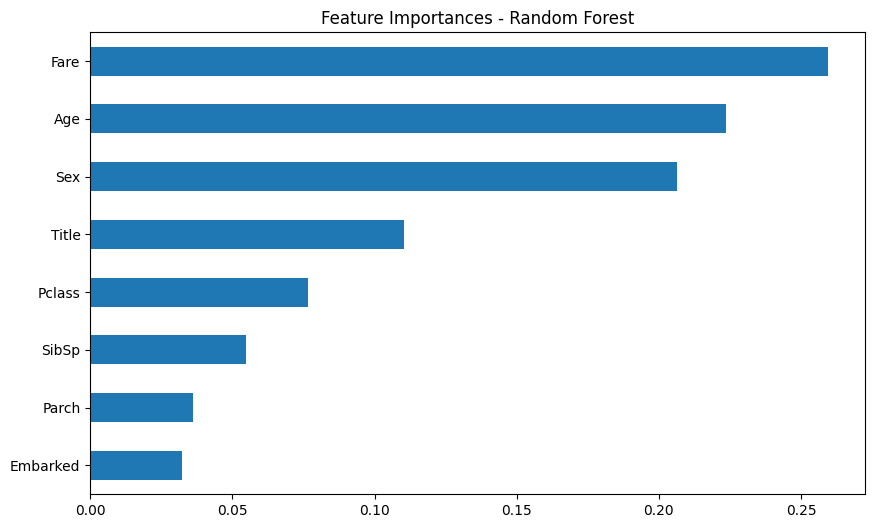

Random Forest Accuracy: 0.8324022346368715


In [65]:
rf = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=42)
rf.fit(X_train, y_train)

# Feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(10,6))
plt.title("Feature Importances - Random Forest")
plt.show()

# Accuracy
rf_preds = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))

##### Visualize a Few Trees from the Forest

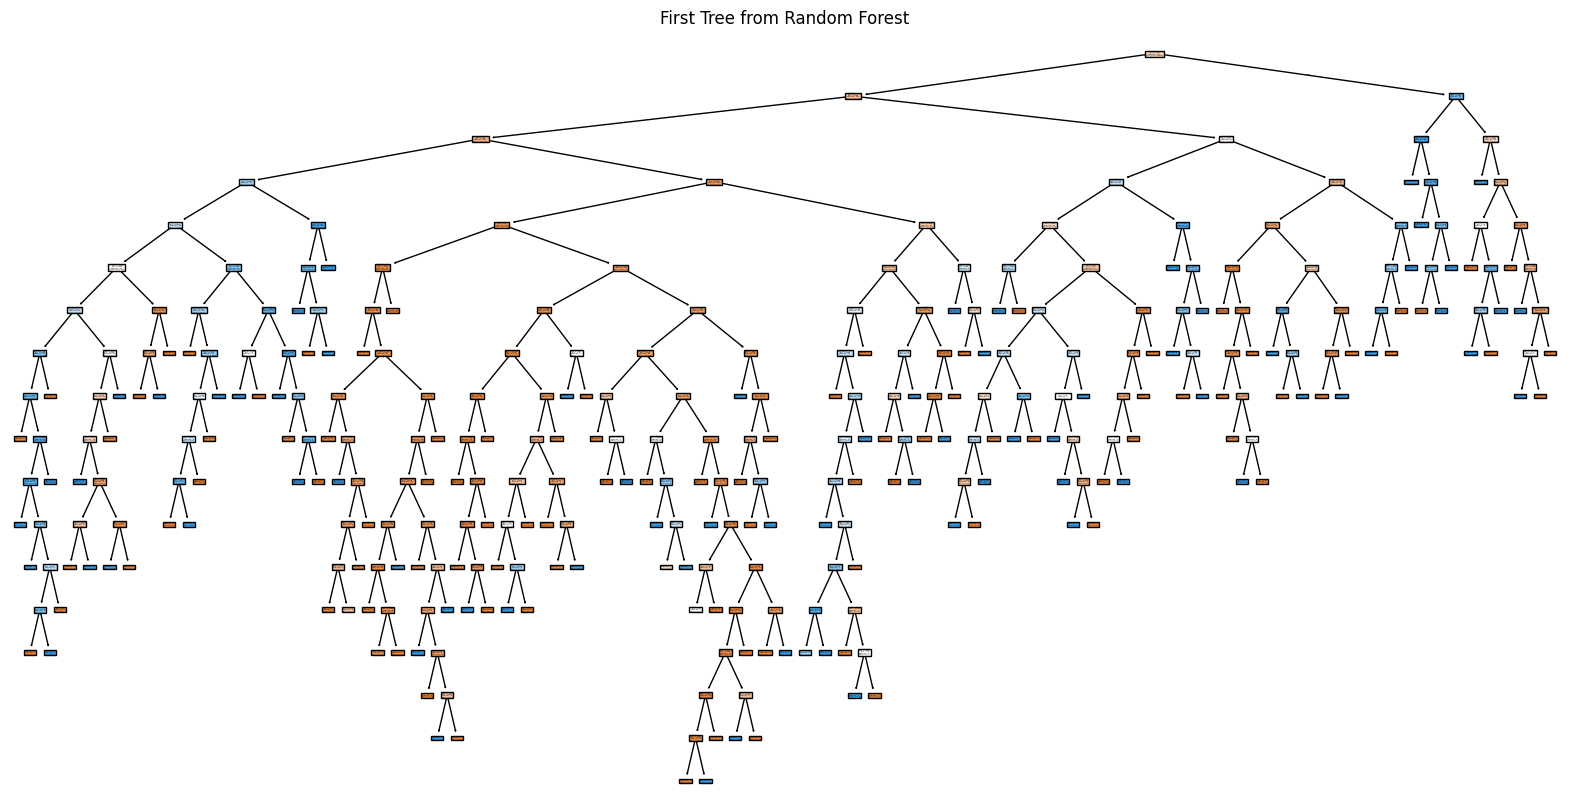

In [66]:
plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[0], feature_names=X.columns, filled=True)
plt.title("First Tree from Random Forest")
plt.show()

### 6. Hyperparameter Tuning

In [67]:
params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

# Refit best model
best_rf = grid_search.best_estimator_
print(best_rf)

Best Params: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Accuracy: 0.8314094356347876
RandomForestClassifier(max_depth=7, n_estimators=200, random_state=42)


### 7. Model Evaluation

In [68]:
final_preds = best_rf.predict(X_test)

cm = confusion_matrix(y_test, final_preds)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[93 12]
 [19 55]]


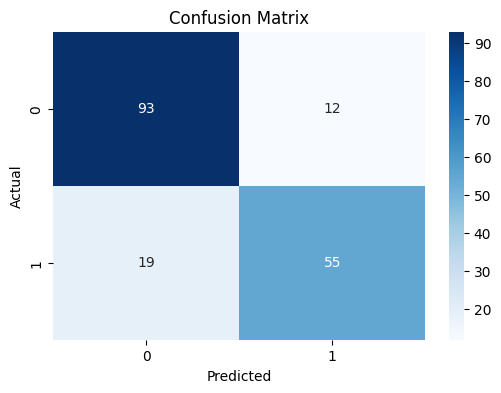

In [69]:
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [70]:
print("\nClassification Report:\n", classification_report(y_test, final_preds))
print("Final Accuracy:", accuracy_score(y_test, final_preds))


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86       105
           1       0.82      0.74      0.78        74

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179

Final Accuracy: 0.8268156424581006


In [71]:
# Saving the model
with open('titanic_survival_model.pkl', 'wb') as file:
    pickle.dump(best_rf, file)

print("Model saved as 'titanic_survival_model.pkl'")

Model saved as 'titanic_survival_model.pkl'
